In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
from random import shuffle

In [2]:
def findFiles(path): return glob.glob(path)
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
category_lines = {}
all_categories = []

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [3]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128


In [5]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [6]:
dataset =[(line,all_categories.index(category)) for category in category_lines for line in category_lines[category]]
shuffle(dataset)
train_data = dataset[:15000]
test_data = dataset[15000:]

In [9]:
rnn = RNN(n_letters, n_hidden, n_categories)
#rnn = rnn.cuda()
criterion = nn.NLLLoss()
optimzer = optim.SGD(rnn.parameters(),lr=0.008)
n_epochs =100

In [10]:
epoch_loss =0
all_losses=[]
for epoch in range(n_epochs):
    epoch_loss=0
    for name,category in train_data:
        line = lineToTensor(name)
        category_tensor = torch.tensor([category], dtype=torch.long)
        #line , category_tensor = Variable(line.cuda()) , Variable(category_tensor.cuda())
        hidden = rnn.initHidden()
        optimzer.zero_grad()
        for i in range(line.size()[0]):
            output, hidden = rnn(line[i], hidden)
        loss = criterion(output, category_tensor)
        #print(loss.data)
        epoch_loss+=loss
        loss.backward()
        optimzer.step()
    print("training loss at epoch {0} is ".format(epoch),(epoch_loss.data)/len(train_data))
    all_losses.append(epoch_loss.data/len(train_data))
    correct=0
    for name,category in test_data:
        line = lineToTensor(name)
        category_tensor = torch.tensor([category], dtype=torch.long)
        #line , category_tensor = Variable(line.cuda()) , Variable(category_tensor.cuda())
        hidden = rnn.initHidden()
        for i in range(line.size()[0]):
            output, hidden = rnn(line[i], hidden)
        _,predicted = categoryFromOutput(output)
        if predicted == category:
            correct+=1
    print("test data accuracy at epoch {0} is ".format(epoch),correct*100/len(test_data))

training loss at epoch 0 is  tensor(1.3656)
test data accuracy at epoch 0 is  67.56011036657469
training loss at epoch 1 is  tensor(1.0802)
test data accuracy at epoch 1 is  70.53606621994481
training loss at epoch 2 is  tensor(0.9908)
test data accuracy at epoch 2 is  71.79739850216791
training loss at epoch 3 is  tensor(0.9414)
test data accuracy at epoch 3 is  72.19156484036263
training loss at epoch 4 is  tensor(0.9154)
test data accuracy at epoch 4 is  72.62514781237682
training loss at epoch 5 is  tensor(0.8933)
test data accuracy at epoch 5 is  72.48718959400867
training loss at epoch 6 is  tensor(0.8788)
test data accuracy at epoch 6 is  72.96018919984233
training loss at epoch 7 is  tensor(0.8694)
test data accuracy at epoch 7 is  73.29523058730784
training loss at epoch 8 is  tensor(0.8618)
test data accuracy at epoch 8 is  72.38864800946
training loss at epoch 9 is  tensor(0.8542)
test data accuracy at epoch 9 is  73.05873078439102
training loss at epoch 10 is  tensor(0.8471

training loss at epoch 84 is  tensor(0.7951)
test data accuracy at epoch 84 is  74.18210484824596
training loss at epoch 85 is  tensor(0.7964)
test data accuracy at epoch 85 is  73.41348048876625
training loss at epoch 86 is  tensor(0.7945)
test data accuracy at epoch 86 is  73.72881355932203
training loss at epoch 87 is  tensor(0.7942)
test data accuracy at epoch 87 is  73.80764682696098
training loss at epoch 88 is  tensor(0.7938)
test data accuracy at epoch 88 is  74.08356326369729
training loss at epoch 89 is  tensor(0.7938)
test data accuracy at epoch 89 is  73.90618841150966
training loss at epoch 90 is  tensor(0.7945)
test data accuracy at epoch 90 is  73.70910524241229
training loss at epoch 91 is  tensor(0.7944)
test data accuracy at epoch 91 is  73.55143870713441
training loss at epoch 92 is  tensor(0.7942)
test data accuracy at epoch 92 is  73.88648009459992
training loss at epoch 93 is  tensor(0.7954)
test data accuracy at epoch 93 is  73.80764682696098
training loss at epo

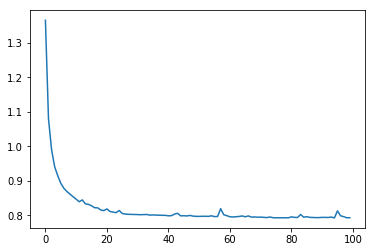

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.savefig("./samples/rnn_name_classification.png")

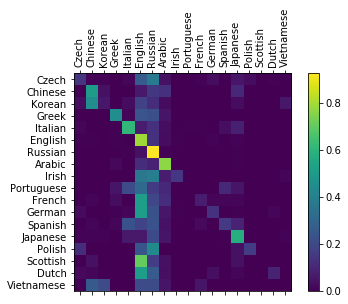

In [20]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for name,category in test_data:
    line = lineToTensor(name)
    category_tensor = torch.tensor([category], dtype=torch.long)
    output = evaluate(line)
    guess, guess_i = categoryFromOutput(output)
    category_i = category
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
#plt.show()
plt.savefig("./samples/test_rnn_name_classificaion.png")